In [ ]:
# AIM OF THIS NOTE BOOK

## optional - download dataset
# https://cs.stanford.edu/~acoates/stl10/
# wget https://raw.githubusercontent.com/mttk/STL10/master/stl10_input.py
# python stl10_input.py

## generate random lines

## overlay lines to images

## train yolo with images with line

In [ ]:
import traceback
import numpy as np
from scipy.interpolate import UnivariateSpline
from scipy.ndimage import binary_dilation
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from extract_centerline import extract_centerline
from scipy.interpolate import UnivariateSpline
def smooth_line(x,y,num=None,**kwargs):
    if num is None:
        num = len(x)
    w = np.arange(0,len(x),1)
    sx = UnivariateSpline(w,x,**kwargs)
    sy = UnivariateSpline(w,y,**kwargs)
    wnew = np.linspace(0,len(x),num)
    return sx(wnew),sy(wnew)

In [ ]:
def make_line(nx=256,ny=256,minlen=50):
    sz = (nx,ny)
    canvas = np.zeros(sz)

    peak_num = np.random.randint(0,10,1)[0]
    for n in range(peak_num):
        x = np.random.choice(np.linspace(0, nx-1, nx),1).astype(np.int)[0]
        y = np.random.choice(np.linspace(0, ny-1, ny),1).astype(np.int)[0]
        canvas[x,y]=1

    distance = ndi.distance_transform_edt(np.logical_not(canvas))
    terrain = ndi.morphology.distance_transform_edt(distance)
    terrain = -1*terrain + -1*np.min(-1*terrain)


    prct = np.random.randint(25,75,1)[0]
    th = np.percentile(terrain.ravel(),prct)
    mask = terrain<th
    mask = np.expand_dims(mask,axis=-1)
    
    count0=0
    while True:
        pt = []
        for n in range(2):
            count1=0
            breakok = False
            while True:
                x = np.random.choice(np.linspace(0, nx-1, nx),1).astype(np.int)[0]
                y = np.random.choice(np.linspace(0, ny-1, ny),1).astype(np.int)[0]
                z = 0
                # determine first point
                if len(pt)==0 and mask[x,y,z] == 1:
                    breakok = True
                # determine second point
                if len(pt)==1 and mask[x,y,z] == 1 and \
                    np.abs(x-pt[0][0]) > minlen and np.abs(y-pt[0][1]) > minlen:
                    breakok = True
                if breakok:
                    break
                count1+=1
                if count1>100:
                    raise LookupError('ok1')
            pt.append((x,y,z))
        start_point = pt[0]
        end_point = pt[1]
        line = extract_centerline(mask,start_point,end_point)
        linexorg,lineyorg,linez=line
        smothing_factor=np.random.rand()*1000
        try:
            linex,liney = smooth_line(linexorg,lineyorg,num=100*len(linexorg),s=smothing_factor)
        except:
            pass
        if len(linexorg) > 5:
            break
            
        count0+=1
        if count0>200:
            raise LookupError('ok0')
            
    mask = mask.squeeze()
    return mask, terrain, linexorg,lineyorg, linex, liney


In [ ]:
# create dataset with multiple lines

def make_one_sample(isplot=False,fignum=0,nx=256,ny=256,baseimage=None,minlen=50):
    if baseimage is None:
        maskorg, orgimage, linexorg,lineyorg, linex, liney = make_line(nx=nx,ny=ny,minlen=minlen)
        myimage = np.copy(orgimage)
    else:
        orgimage = np.copy(baseimage)
        myimage = np.copy(baseimage)
        
    mymax = np.max(myimage)
    linmax = np.random.randint(1,5,1)[0]
    container = []
    for x in range(linmax):
        prct = np.random.randint(75,100,1)[0]
        mymax = np.percentile(orgimage.ravel(),prct)
        _, _, linexorg,lineyorg, linex, liney = make_line(nx=nx,ny=ny,minlen=minlen)
        mask = np.zeros(myimage.shape)
        for x,y in zip(linex,liney):
            try:
                myimage[x.astype(int),y.astype(int)]=mymax
                mask[x.astype(int),y.astype(int)]=1
            except:
                pass
        endpoints = [[linex[0], liney[0]],[linex[-1], liney[-1]]]
        container.append({
            'mask':mask,
            'endpoints':endpoints,
        })
    if isplot:
        fig = plt.figure(fignum,figsize=(20,20))
        plt.subplot(121)
        plt.imshow(orgimage,cmap='gray',origin='lower')
        plt.subplot(122)
        for item in container:
            plt.scatter(item['endpoints'][0][1],item['endpoints'][0][0],300,'green',marker='+')
            plt.scatter(item['endpoints'][1][1],item['endpoints'][1][0],300,'green',marker='+',)
        plt.imshow(myimage,cmap='gray',origin='lower')
        plt.xlim(0,nx)
        plt.ylim(0,ny)
        
    return myimage, container

terrain, container = make_one_sample(isplot=True)

In [ ]:
import SimpleITK as sitk
from PIL import Image
from skimage.transform import rescale
import yaml

def imread(fpath):
    reader= sitk.ImageFileReader()
    reader.SetFileName(fpath)
    img = reader.Execute()
    arr = sitk.GetArrayFromImage(img)    
    spacing = img.GetSpacing()
    origin = img.GetOrigin()
    direction = img.GetDirection()    
    return arr,spacing,origin,direction

with open('/media/external/Downloads/data/luna16.yml','r') as f:
    luna16 = yaml.load(f.read())

def get_xray(isplot=False,fignum=0):
    
    filepath = np.random.choice(luna16)
    img,spacing,origin,direction = imread(filepath)
    xray = np.sum(img,axis=1)
    xray = (255.0 * (xray - xray.min())/(xray.max()-xray.min()))

    new_width = 256
    new_height = 256
    xray = rescale(xray,
                (spacing[2],spacing[0]),
                 anti_aliasing=True)
    xray = xray.astype(np.uint8)
    xray = Image.fromarray(xray,mode="L")
    xray = xray.resize((new_width, new_height), Image.ANTIALIAS)
    xray = np.array(xray)
    xray, container = make_one_sample(isplot=isplot,fignum=fignum,nx=256,ny=256,baseimage=xray)
    return xray, container

    #im = Image.fromarray(xray,mode="L")
    #im = im.resize((new_width, new_height), Image.ANTIALIAS)
    #im.save('testXray.png',"PNG")


In [ ]:
for n in range(5):
    try:
        xray, container = get_xray(isplot=True,fignum=n)
    except:
        pass
        traceback.print_exc()


In [ ]:
for n in range(3):
    try:
        terrain, container = make_one_sample(nx=64,ny=64,minlen=10,
            isplot=True,fignum=n,)
    except:
        pass
        traceback.print_exc()

In [ ]:
szx,szy,szz=64,64,64
smx,smy=8,8
grid = np.zeros((szx,szy)).astype(np.uint)

anchor_dict={}
for x in range(szx):
    for y in range(szy):
        px = x//smx
        py = y//smy
        code = py + smx*px
        if code not in anchor_dict.keys():
            anchor_dict[code]=(x,y)
        grid[x,y]=code
        
plt.imshow(grid)
print(np.unique(grid))

In [ ]:
# x  (None,64,64)
# y0 (None,64,5)     - object,relstartx,relstarty,shapex,shapey
# y1 (None,64,64,64) - 64x(64,64) mask

In [ ]:
def make_data(N=5):
    X0 = np.zeros((N,szx,szy)).astype(np.uint8)
    Y0 = np.zeros((N,szz,5)).astype(np.float)
    Y1 = np.zeros((N,szx,szy,szz)).astype(np.uint8)

    c=0
    for n in range(N*100):
        try:
            # make random line
            terrain, container = make_one_sample(nx=64,ny=64,minlen=10)
            # rescale input image
            terrain = (255*(terrain-np.max(terrain))/(np.max(terrain)-np.min(terrain))).astype(np.uint8)
            # for each line
            for row in container:
                # get mask and end points
                mask=row['mask'].astype(np.uint8)
                endpoints = np.array(row['endpoints']).astype(np.int)
                x0,y0=endpoints[0,:]
                x1,y1=endpoints[1,:]
                # ensure end points in line
                #assert(mask[x0,y0]==1 and mask[x1,y1]==1)

                istube=1
                # find min max point
                mask_indices = np.argwhere(mask>0)

                minx=np.min(mask_indices[:,0])
                miny=np.min(mask_indices[:,1])

                maxx=np.max(mask_indices[:,0])
                maxy=np.max(mask_indices[:,1])

                medx=np.median(mask_indices[:,0]).astype(np.int)
                medy=np.median(mask_indices[:,1]).astype(np.int)

                ind = grid[minx,miny]
                # get anchor in grid
                anchorx,anchory=anchor_dict[ind]
                # get rel start
                relstartx = minx-anchorx
                relstarty = miny-anchory
                # rel x
                relendx = maxx-minx
                relendy = maxy-miny
                # assign ys
                relstartx /= szx
                relstarty /= szy
                relendx /= szx
                relendy/= szy
                yolo = np.array([istube,relstartx,relstarty,relendx,relendy])
                #print(Y0[c,ind,:].shape,yolo.shape)
                
                Y0[c,ind,:]=yolo
                Y1[c,ind,:,:]=mask
            
            X0[c,:,:]=terrain
        
        except:
            if c >= N:
                break
            X0[c,:,:]=0
            Y0[c,:,:]=0
            Y1[c,:,:,:]=0
        
        if c>=N:
            break
        
        c+=1
        
    return X0,Y0,Y1


In [12]:
X0,Y0,Y1 = make_data(N=5)
c=0
ind = 0
for aind in range(smx*smy):    
    y0 = Y0[ind,aind,:]
    istube,relsx,relsy,relex,reley = y0
    if istube == 0:
        continue
    
    tmp = Y1[ind,aind,:,:]
    
    ax,ay = anchor_dict[aind]
    
    startx = ax+relsx*szx
    starty = ay+relsy*szy
    
    endx = startx+relex*szx
    endy = starty+reley*szy
    
    startx = startx.astype(np.int)
    starty = starty.astype(np.int)
    endx = endx.astype(np.int)
    endy = endy.astype(np.int)
    
    tmp[ax,ay]=2
    tmp[startx,starty]=3
    tmp[endx,endy]=3

    plt.figure(c)    
    plt.title('{}'.format(y0))
    plt.imshow(tmp,cmap='gray',origin='upper')    
    c+=1
    
plt.figure(c)
plt.imshow(X0[ind,])

In [13]:
x_train, y_train0, y_train1 = make_data(N=1000)
x_train = np.expand_dims(x_train,axis=-1)
x_val, y_val0, y_val1 = make_data(N=100)
x_val = np.expand_dims(x_val,axis=-1)

In [14]:
ind = -3
plt.subplot(121)
plt.imshow(x_train[ind,:].squeeze())
region = np.argwhere(y_train0[ind,:,0]==1)[0][0]
plt.subplot(122)
plt.imshow(y_trai1[ind,region,:,:])


In [15]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)

from keras.models import Sequential, load_model
from keras import optimizers as opt
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Reshape
from keras.callbacks import LearningRateScheduler


Using TensorFlow backend.


In [158]:


# simple yolo
#   https://gist.github.com/msrks/ce613e91a98868d4a059c6c5c5e30ba3
# vanillay conv cannot prediction coord
#   https://eng.uber.com/coordconv/
# alternative archetecture.
#   https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e
#   https://github.com/jianing-sun/Mask-YOLO



lambda_pos = 1.0

def yolo_loss(y_true, y_pred):
    
    loss = tf.Variable(tf.zeros([1]))
    for n in range(smx*smy):
        loss_obj = tf.keras.backend.binary_crossentropy(y_true[:,n,0], y_pred[:,n,0])
        
        loss_st_x = tf.squared_difference(y_true[:,n,1], y_pred[:,n,1])
        loss_st_y = tf.squared_difference(y_true[:,n,2], y_pred[:,n,2])
        loss_sz_x = tf.squared_difference(y_true[:,n,3], y_pred[:,n,3])
        loss_sz_y = tf.squared_difference(y_true[:,n,4], y_pred[:,n,4])

        loss_pos = tf.multiply(tf.multiply(lambda_pos, y_true[:,n,0]),tf.add(loss_st_x,loss_st_y))
        loss_sz = tf.multiply(tf.multiply(lambda_pos, y_true[:,n,0]),tf.add(loss_sz_x,loss_sz_y))
        newloss = tf.add(loss_obj,tf.add(loss_pos,loss_sz))
        loss = tf.add(loss,newloss)
    loss = tf.add(loss,newloss)
    return tf.reduce_mean(loss)
    '''
    
    #shape = y_true.get_shape().as_list()
    #dim = np.prod(shape[1:])    
    #y_true = tf.reshape(y_true, [-1, dim])
    #y_pred = tf.reshape(y_pred, [-1, dim])
    
    loss_obj = tf.keras.backend.binary_crossentropy(y_true[:,:,0], y_pred[:,:,0])
    loss_st_x = tf.squared_difference(y_true[:,:,1], y_pred[:,:,1])
    loss_st_y = tf.squared_difference(y_true[:,:,2], y_pred[:,:,2])
    loss_sz_x = tf.squared_difference(y_true[:,:,3], y_pred[:,:,3])
    loss_sz_y = tf.squared_difference(y_true[:,:,4], y_pred[:,:,4])

    loss_pos = tf.multiply(tf.multiply(lambda_pos, y_true[:,:,0]),tf.add(loss_st_x,loss_st_y))
    loss_sz = tf.multiply(tf.multiply(lambda_pos, y_true[:,:,0]),tf.add(loss_sz_x,loss_sz_y))
    loss = tf.add(loss_obj,tf.add(loss_pos,loss_sz))
    return tf.reduce_mean(loss)
    '''
model = Sequential()

model.add(Conv2D(16, 3, input_shape=(szx,szy,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(16, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(16, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(16, 3))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(smx*smy*5))
model.add(Reshape((smx*smy,5)))
model.add(Activation('sigmoid'))
model.summary()
print(x_train.shape,y_train0.shape,y_train1.shape)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_109 (Conv2D)          (None, 62, 62, 16)        160       
_________________________________________________________________
activation_190 (Activation)  (None, 62, 62, 16)        0         
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 29, 29, 16)        2320      
_________________________________________________________________
activation_191 (Activation)  (None, 29, 29, 16)        0         
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 12, 12, 16)        2320      
__________

In [159]:
# opt.Adam, opt.RMSprop
model.compile(loss=yolo_loss, optimizer=opt.RMSprop(lr=0.001))
history = model.fit(x_train, y_train0,
                    batch_size=128, epochs=100,
                    verbose=1, validation_data=(x_val, y_val0))

Train on 1000 samples, validate on 100 samples
Epoch 1/100
1000/1000 [==============================] - 23s 23ms/step - loss: 64.0394 - val_loss: 36.1195
Epoch 2/100
1000/1000 [==============================] - 1s 543us/step - loss: 34.0367 - val_loss: 18.8620
Epoch 3/100
1000/1000 [==============================] - 1s 543us/step - loss: 24.2962 - val_loss: 14.5749
Epoch 4/100
1000/1000 [==============================] - 1s 537us/step - loss: 19.3086 - val_loss: 11.0684
Epoch 5/100
1000/1000 [==============================] - 1s 541us/step - loss: 17.0217 - val_loss: 10.6458
Epoch 6/100
1000/1000 [==============================] - 1s 550us/step - loss: 15.1044 - val_loss: 10.3221
Epoch 7/100
1000/1000 [==============================] - 1s 547us/step - loss: 14.3234 - val_loss: 10.2494
Epoch 8/100
1000/1000 [==============================] - 1s 541us/step - loss: 12.9474 - val_loss: 10.3242
Epoch 9/100
1000/1000 [==============================] - 1s 539us/step - loss: 12.1442 - val_loss

1000/1000 [==============================] - 1s 544us/step - loss: 8.5225 - val_loss: 9.2358
Epoch 78/100
1000/1000 [==============================] - 1s 543us/step - loss: 8.4522 - val_loss: 9.2000
Epoch 79/100
1000/1000 [==============================] - 1s 544us/step - loss: 8.5554 - val_loss: 9.3427
Epoch 80/100
1000/1000 [==============================] - 1s 556us/step - loss: 8.4871 - val_loss: 9.3873
Epoch 81/100
1000/1000 [==============================] - 1s 550us/step - loss: 8.4855 - val_loss: 9.2165
Epoch 82/100
1000/1000 [==============================] - 1s 541us/step - loss: 8.4905 - val_loss: 9.3285
Epoch 83/100
1000/1000 [==============================] - 1s 559us/step - loss: 8.4369 - val_loss: 9.2101
Epoch 84/100
1000/1000 [==============================] - 1s 538us/step - loss: 8.4499 - val_loss: 9.3241
Epoch 85/100
1000/1000 [==============================] - 1s 552us/step - loss: 8.4272 - val_loss: 9.2028
Epoch 86/100
1000/1000 [==============================] - 1

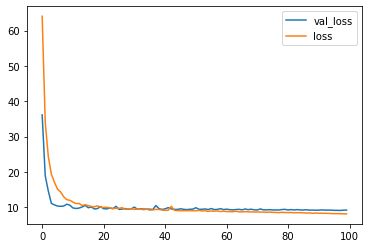

In [162]:
import pandas as pd
df = pd.DataFrame(history.history)
df.plot()

In [163]:
x_test, y_test0, y_test1 = make_data(N=5)
x_test = np.expand_dims(x_test,axis=-1)

In [164]:
#x_test, y_test0, y_test1 = x_train, y_train0, y_train1
pred = model.predict(x_test)

In [165]:
pred.shape

(5, 64, 5)

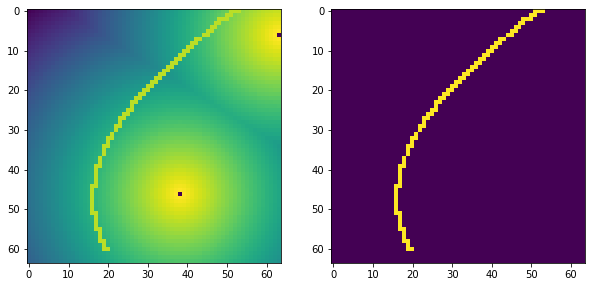

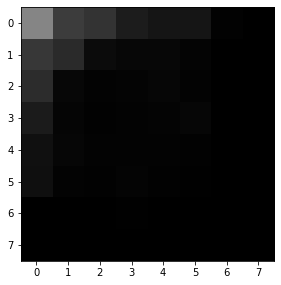

In [166]:
ind = 0
plt.figure(0,figsize=(10,10))
plt.subplot(121)
plt.imshow(x_test[ind,:].squeeze())
region = np.argwhere(y_test0[ind,:,0]==1)[0][0]
plt.subplot(122)
plt.imshow(y_test1[ind,region,:,:])
plt.figure(1,figsize=(10,10))
obj = np.reshape(pred[ind,:,0],(smx,smy))
plt.subplot(121)
plt.imshow(obj,vmin=0,vmax=1,cmap='gray')

In [ ]:
plt.plot(pred[ind,:,0])